# Faster R CNN

In [1]:
import random, os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
available_models = [model for model in dir(torchvision.models.detection) if not model.startswith("__")]

In [4]:
print("Available detection models in torchvision:")
for model in available_models:
    print(model)

Available detection models in torchvision:
FCOS
FCOS_ResNet50_FPN_Weights
FasterRCNN
FasterRCNN_MobileNet_V3_Large_320_FPN_Weights
FasterRCNN_MobileNet_V3_Large_FPN_Weights
FasterRCNN_ResNet50_FPN_V2_Weights
FasterRCNN_ResNet50_FPN_Weights
KeypointRCNN
KeypointRCNN_ResNet50_FPN_Weights
MaskRCNN
MaskRCNN_ResNet50_FPN_V2_Weights
MaskRCNN_ResNet50_FPN_Weights
RetinaNet
RetinaNet_ResNet50_FPN_V2_Weights
RetinaNet_ResNet50_FPN_Weights
SSD300_VGG16_Weights
SSDLite320_MobileNet_V3_Large_Weights
_utils
anchor_utils
backbone_utils
faster_rcnn
fasterrcnn_mobilenet_v3_large_320_fpn
fasterrcnn_mobilenet_v3_large_fpn
fasterrcnn_resnet50_fpn
fasterrcnn_resnet50_fpn_v2
fcos
fcos_resnet50_fpn
generalized_rcnn
image_list
keypoint_rcnn
keypointrcnn_resnet50_fpn
mask_rcnn
maskrcnn_resnet50_fpn
maskrcnn_resnet50_fpn_v2
retinanet
retinanet_resnet50_fpn
retinanet_resnet50_fpn_v2
roi_heads
rpn
ssd
ssd300_vgg16
ssdlite
ssdlite320_mobilenet_v3_large
transform


## Load Model

In [5]:
def load_model_preprocesser():
    weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn_v2(weights=weights)
    preprocesser = weights.transforms()
    categories = weights.meta["categories"]
    return model, categories, preprocesser

In [6]:
model, categories, preprocesser = load_model_preprocesser()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:01<00:00, 163MB/s]


In [10]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [11]:
categories

['__background__',
 'person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'N/A',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'N/A',
 'backpack',
 'umbrella',
 'N/A',
 'N/A',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'N/A',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'N/A',
 'dining table',
 'N/A',
 'N/A',
 'toilet',
 'N/A',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'N/A',
 'book',
 'clock',
 'vase',
 'scissors',
 'ted

## Prediction

In [12]:
def prediction(img_path, categories, preprocesser, model, n=1):

    img = read_image(img_path)

    input_tensor = preprocesser(img)

    input_batch = input_tensor.unsqueeze(0)

    model.eval()

    with torch.no_grad():
        prediction = model(input_batch)[0]


    top_indices = prediction['scores'].topk(n).indices

    labels = [categories[prediction['labels'][i].item()] for i in top_indices]


    boxes = [prediction['boxes'][i].tolist() for i in top_indices]

    return input_tensor, labels, boxes


In [13]:
img_path = "/content/drive/MyDrive/Colab Notebooks/imagenet_samples/Eskimo_dog.jpeg"

In [14]:
input_tensor, labels, boxes = prediction(img_path, categories, preprocesser, model)

In [15]:
input_tensor

tensor([[[0.9922, 0.9961, 0.9961,  ..., 0.9451, 0.9490, 0.9490],
         [0.9922, 0.9961, 0.9961,  ..., 0.9490, 0.9569, 0.9490],
         [0.9922, 0.9961, 1.0000,  ..., 0.9529, 0.9529, 0.9451],
         ...,
         [1.0000, 0.9961, 1.0000,  ..., 0.9882, 0.9961, 1.0000],
         [1.0000, 0.9961, 1.0000,  ..., 1.0000, 0.9961, 1.0000],
         [1.0000, 0.9922, 0.9961,  ..., 0.9961, 0.9961, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.9098, 0.9137, 0.9137],
         [1.0000, 1.0000, 1.0000,  ..., 0.9137, 0.9098, 0.9137],
         [1.0000, 1.0000, 1.0000,  ..., 0.9059, 0.9020, 0.8980],
         ...,
         [1.0000, 0.9961, 1.0000,  ..., 0.9882, 0.9961, 1.0000],
         [1.0000, 0.9961, 1.0000,  ..., 1.0000, 0.9961, 1.0000],
         [1.0000, 0.9922, 0.9961,  ..., 0.9961, 0.9961, 1.0000]],

        [[0.9961, 1.0000, 1.0000,  ..., 0.8431, 0.8471, 0.8471],
         [0.9961, 1.0000, 1.0000,  ..., 0.8471, 0.8471, 0.8471],
         [0.9961, 1.0000, 1.0000,  ..., 0.8431, 0.8392, 0.

In [16]:
labels

['cat']

In [17]:
boxes

[[73.7698745727539,
  14.346980094909668,
  248.45904541015625,
  193.84251403808594]]

# Detect Objects

In [18]:
def detect_objects(input_tensor, labels, boxes):
    img = to_pil_image(input_tensor)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    ax.axis('off')
    for box, label in zip(boxes, labels):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        plt.text(box[0], box[1] - 20, label, color='red', fontsize=15, verticalalignment='top')
    plt.show()


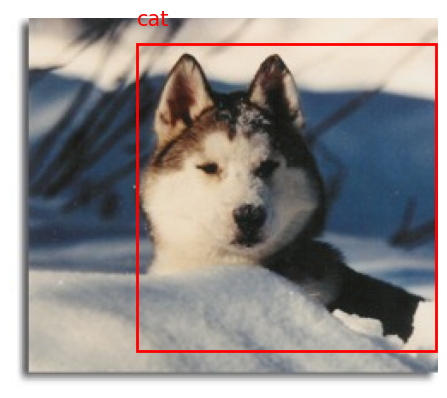

In [19]:
detect_objects(input_tensor, labels, boxes)

In [20]:
def get_image_paths(root_dir, num_images=None):
    all_images = []
    for extension in ['*.jpg', '*.jpeg', '*.png']:
        all_images.extend(glob(os.path.join(root_dir, '**', extension), recursive=True))
    if num_images is None:
        return all_images
    else:
        return random.sample(all_images, min(num_images, len(all_images)))

In [21]:
directory_path = "/content/drive/MyDrive/Colab Notebooks/imagenet_samples/"

In [22]:
image_paths = get_image_paths(directory_path, 10)

In [23]:
for img_path in image_paths:
    input_tensor, labels, boxes = prediction(img_path, categories, preprocesser, model)
    detect_objects(input_tensor, labels, boxes)

Output hidden; open in https://colab.research.google.com to view.

In [24]:
directory_path = "/content/drive/MyDrive/Colab Notebooks/multiple_objects"

In [25]:
image_paths = get_image_paths(directory_path)

In [26]:
for img_path in image_paths:
    input_tensor, labels, boxes = prediction(img_path, categories, preprocesser, model, n=5)
    detect_objects(input_tensor, labels, boxes)

Output hidden; open in https://colab.research.google.com to view.

In [30]:
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights)
preprocesser = weights.transforms()
categories = weights.meta["categories"]

In [31]:
img = read_image("/content/drive/MyDrive/Colab Notebooks/imagenet_samples/Eskimo_dog.jpeg")

In [33]:
input_tensor = preprocesser(img)

In [34]:
input_batch = input_tensor.unsqueeze(0)

In [35]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [36]:
prediction = model(input_batch)

In [37]:
prediction = model(input_batch)[0]

In [38]:
labels = [weights.meta["categories"][i] for i in prediction["labels"]]

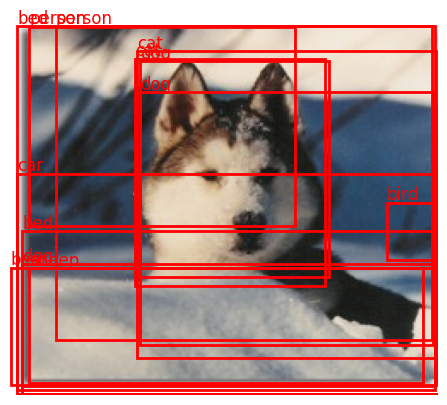

In [39]:
img = to_pil_image(input_tensor)
fig, ax = plt.subplots(1)
ax.imshow(img)
ax.axis('off')

for box, label in zip(prediction['boxes'], labels):
    box = box.detach().numpy()
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    plt.text(box[0], box[1]-10, label, color='red', fontsize=12, verticalalignment='top')

plt.show()

# Mask R CNN

In [43]:
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from glob import glob
import random

def load_model_preprocesser():
    weights = MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    model = maskrcnn_resnet50_fpn_v2(weights=weights)
    preprocesser = weights.transforms()
    categories = weights.meta["categories"]
    return model, categories, preprocesser

model, categories, preprocesser = load_model_preprocesser()

def prediction(img_path, categories, preprocesser, model):
    img = read_image(img_path)
    input_tensor = preprocesser(img)
    input_batch = input_tensor.unsqueeze(0)
    model.eval()
    with torch.no_grad():
        predictions = model(input_batch)[0]
    max_score_index = predictions['scores'].argmax().item()
    max_score_label = predictions['labels'][max_score_index].item()
    max_score_box = predictions['boxes'][max_score_index]
    max_score_mask = predictions['masks'][max_score_index, 0]
    labels = [categories[max_score_label]]
    boxes = [max_score_box]
    masks = [max_score_mask]

    return input_tensor, labels, boxes, masks


def detect_objects(input_tensor, labels, boxes, masks):
    img = to_pil_image(input_tensor)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    ax1.imshow(img)
    ax1.axis('off')
    for box, label in zip(boxes, labels):
        box = box.detach().numpy()
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='red', facecolor='none')
        ax1.add_patch(rect)
        ax1.text(box[0], box[1] - 20, label, color='red', fontsize=15, verticalalignment='top')
    ax2.imshow(img)
    ax2.imshow(masks[0].detach().cpu(), alpha=0.5, cmap='jet')
    ax2.axis('off')

    plt.show()


def get_image_paths(root_dir, num_images=None):
    all_images = []
    for extension in ['*.jpg', '*.jpeg', '*.png']:
        all_images.extend(glob(os.path.join(root_dir, '**', extension), recursive=True))
    if num_images is None:
        return all_images
    else:
        return random.sample(all_images, min(num_images, len(all_images)))


directory_path = "/content/drive/MyDrive/Colab Notebooks/imagenet_samples/"
image_paths = get_image_paths(directory_path, num_images=10)

for img_path in image_paths:
    input_tensor, labels, boxes, masks = prediction(img_path, categories, preprocesser, model)
    detect_objects(input_tensor, labels, boxes, masks)


Output hidden; open in https://colab.research.google.com to view.

# SSD (Single Shot Multibox Detector)

In [45]:
import torch
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from glob import glob
import random

def load_model_preprocesser():
    weights = SSD300_VGG16_Weights.DEFAULT
    model = ssd300_vgg16(weights=weights)
    preprocesser = weights.transforms()
    categories = weights.meta["categories"]
    return model, categories, preprocesser

model, categories, preprocesser = load_model_preprocesser()

def prediction(img_path, categories, preprocesser, model, n=1):
    img = read_image(img_path)
    input_tensor = preprocesser(img)
    input_batch = input_tensor.unsqueeze(0)
    model.eval()
    with torch.no_grad():
        prediction = model(input_batch)[0]
    top_indices = prediction['scores'].topk(n).indices
    labels = [categories[prediction['labels'][i].item()] for i in top_indices]
    boxes = [prediction['boxes'][i].tolist() for i in top_indices]
    return input_tensor, labels, boxes

def detect_objects(input_tensor, labels, boxes):
    img = to_pil_image(input_tensor)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    ax.axis('off')
    for box, label in zip(boxes, labels):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        plt.text(box[0], box[1] - 20, label, color='red', fontsize=15, verticalalignment='top')
    plt.show()


def get_image_paths(root_dir, num_images=None):
    all_images = []
    for extension in ['*.jpg', '*.jpeg', '*.png']:
        all_images.extend(glob(os.path.join(root_dir, '**', extension), recursive=True))
    if num_images is None:
        return all_images
    else:
        return random.sample(all_images, min(num_images, len(all_images)))


directory_path = "/content/drive/MyDrive/Colab Notebooks/multiple_objects"
image_paths = get_image_paths(directory_path)





Output hidden; open in https://colab.research.google.com to view.

In [47]:
for img_path in image_paths:
    input_tensor, labels, boxes = prediction(img_path, categories, preprocesser, model, 20)
    detect_objects(input_tensor, labels, boxes)

Output hidden; open in https://colab.research.google.com to view.

# RetinaNet



In [48]:
import torch
from torchvision.models.detection import retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from glob import glob
import random


def load_model_praeprocesser():
    weights = RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT
    model = retinanet_resnet50_fpn_v2(weights=weights)
    preprocesser = weights.transforms()
    categories = weights.meta["categories"]
    return model, categories, preprocesser

model, categories, preprocesser = load_model_preprocesser()

def prediction(img_path, categories, preprocesser, model, n=1):
    img = read_image(img_path)
    input_tensor = preprocesser(img)
    input_batch = input_tensor.unsqueeze(0)
    model.eval()
    with torch.no_grad():
        prediction = model(input_batch)[0]
    top_indices = prediction['scores'].topk(n).indices
    labels = [categories[prediction['labels'][i].item()] for i in top_indices]
    boxes = [prediction['boxes'][i].tolist() for i in top_indices]
    return input_tensor, labels, boxes



def detect_objects(input_tensor, labels, boxes):
    img = to_pil_image(input_tensor)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    ax.axis('off')
    for box, label in zip(boxes, labels):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        plt.text(box[0], box[1] - 20, label, color='red', fontsize=15, verticalalignment='top')
    plt.show()


def get_image_paths(root_dir, num_images=None):
    all_images = []
    for extension in ['*.jpg', '*.jpeg', '*.png']:
        all_images.extend(glob(os.path.join(root_dir, '**', extension), recursive=True))
    if num_images is None:
        return all_images
    else:
        return random.sample(all_images, min(num_images, len(all_images)))


directory_path = "/content/drive/MyDrive/Colab Notebooks/multiple_objects"
image_paths = get_image_paths(directory_path)



In [49]:
for img_path in image_paths:
    input_tensor, labels, boxes = prediction(img_path, categories, preprocesser, model, 5)
    detect_objects(input_tensor, labels, boxes)


Output hidden; open in https://colab.research.google.com to view.

In [50]:
img_path = "/content/drive/MyDrive/Colab Notebooks/imagenet_samples/Eskimo_dog.jpeg"

In [53]:
input_tensor, labels, boxes = prediction(img_path, categories, preprocesser, model, 1)

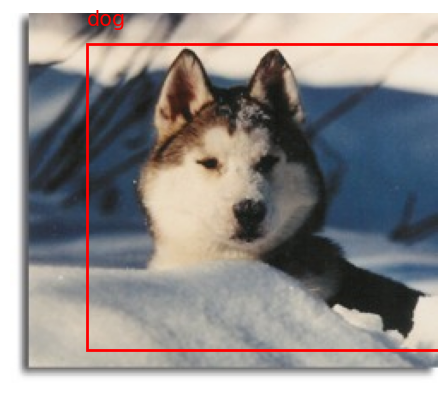

In [54]:
detect_objects(input_tensor, labels, boxes)

# YOLO V8

In [ ]:
# !pip install ultralytics

In [1]:
import random, os
from glob import glob
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [2]:
model = YOLO('yolov8n.pt')

In [3]:
def get_image_paths(root_dir, num_images=None):
    all_images = []
    for extension in ['*.jpg', '*.jpeg', '*.png']:
        all_images.extend(glob(os.path.join(root_dir, '**', extension), recursive=True))
    if num_images is None:
        return all_images
    else:
        return random.sample(all_images, min(num_images, len(all_images)))

In [4]:
directory_path = "/content/drive/MyDrive/Colab Notebooks/multiple_objects/"

In [5]:
image_paths = get_image_paths(directory_path)

In [6]:
results = model(image_paths)


0: 640x640 3 persons, 1 truck, 2 horses, 90.1ms
1: 640x640 2 airplanes, 2 trucks, 90.1ms
2: 640x640 1 person, 2 bicycles, 7 cars, 1 backpack, 90.1ms
3: 640x640 1 traffic light, 4 wine glasss, 2 cups, 1 bowl, 2 dining tables, 90.1ms
4: 640x640 13 apples, 5 oranges, 90.1ms
5: 640x640 1 cup, 5 bowls, 1 sandwich, 11 oranges, 3 potted plants, 1 microwave, 1 oven, 90.1ms
6: 640x640 2 persons, 2 tennis rackets, 90.1ms
7: 640x640 1 person, 6 cars, 2 buss, 1 truck, 2 traffic lights, 90.1ms
8: 640x640 3 bottles, 4 wine glasss, 90.1ms
9: 640x640 3 zebras, 2 giraffes, 90.1ms
Speed: 6.5ms preprocess, 90.1ms inference, 247.5ms postprocess per image at shape (1, 3, 640, 640)


In [7]:
for i, r in enumerate(results):

    im_bgr = r.plot()
    im_rgb = Image.fromarray(im_bgr[..., ::-1])

    plt.figure(figsize=(10, 10))
    plt.imshow(im_rgb)
    plt.axis('off')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# YOLOv3 with Open CV

## Imports

In [9]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import random, os
import numpy as np
from glob import glob

## Config Files and Class Names

In [10]:
config = "/content/drive/MyDrive/Colab Notebooks/yolo_files/yolov3.cfg"

weights = "/content/drive/MyDrive/Colab Notebooks/yolo_files/yolov3.weights"

labels_path = "/content/drive/MyDrive/Colab Notebooks/yolo_files/coco.names"

with open(labels_path, 'r') as f:
    classes = f.read().strip().split('\n')

## Load Model

In [11]:
def load_yolo_model(config_path, weights_path):

    net = cv2.dnn.readNetFromDarknet(config_path, weights_path)

    layer_names = net.getLayerNames()

    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]

    return net, output_layers

In [12]:
net, output_layers = load_yolo_model(config, weights)

## Detect Objects

In [13]:
def detect_objects(net, image, output_layers):

    height, width, _ = image.shape
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)


    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]

            class_id = np.argmax(scores)

            confidence = scores[class_id]

            if confidence > 0.5:

                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)

                w = int(detection[2] * width)

                h = int(detection[3] * height)

                x = int(center_x - w / 2)

                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])

                confidences.append(float(confidence))

                class_ids.append(class_id)

    return boxes, confidences, class_ids


In [14]:
image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/multiple_objects/airport.jpg")

In [15]:
boxes, confidences, class_ids = detect_objects(net, image, output_layers)

## Visualize Prediction

In [16]:
def draw_labels(boxes, confidences, class_ids, classes, image):
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = confidences[i]
            color = (0, 255, 0)
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            cv2.putText(image, f"{label} {round(confidence, 2)}", (x, y + 30), font, 2, color, 2)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

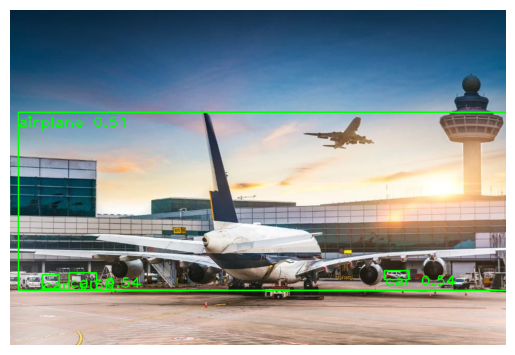

In [17]:
draw_labels(boxes, confidences, class_ids, classes, image)

In [18]:
def get_image_paths(root_dir, num_images=None):
    all_images = []
    for extension in ['*.jpg', '*.jpeg', '*.png']:
        all_images.extend(glob(os.path.join(root_dir, '**', extension), recursive=True))
    if num_images is None:
        return all_images
    else:
        return random.sample(all_images, min(num_images, len(all_images)))

In [19]:
directory_path = "/content/drive/MyDrive/Colab Notebooks/multiple_objects"
image_paths = get_image_paths(directory_path)

for img_path in image_paths:
    image = cv2.imread(img_path)
    boxes, confidences, class_ids = detect_objects(net, image, output_layers)
    draw_labels(boxes, confidences, class_ids, classes, image)

Output hidden; open in https://colab.research.google.com to view.

In [25]:
image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/imagenet_samples/Eskimo_dog.jpeg")

In [27]:
boxes, confidences, class_ids = detect_objects(net, image, output_layers)

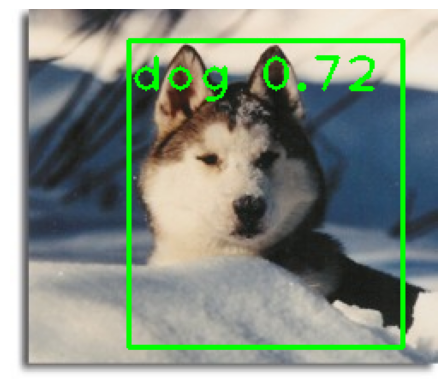

In [28]:
draw_labels(boxes, confidences, class_ids, classes, image)